In [1]:
from numpy import average
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, to_categorical
from sklearn.metrics import roc_auc_score
import scipy.special
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sys

from energyflow.archs.dnn import DNN
from energyflow.datasets import qg_nsubs
from energyflow.utils import data_split, to_categorical

try:
    from rikabplotlib.plot_utils import newplot, stamp, add_whitespace
except:
    from utils.plot_utils import newplot, stamp

from sklearn.metrics import roc_auc_score, roc_curve

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPUs Available: ", tf.config.list_physical_devices('GPU'))

2024-03-13 00:48:12.097784: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


Num GPUs Available:  0
GPUs Available:  []


/home/rikab/Documents/Research/MomentAnalysis/energyflow/archs/__init__.py:30: UserWarning: could not import some architectures - cannot import name 'cnn' from partially initialized module 'energyflow.archs' (most likely due to a circular import) (/home/rikab/Documents/Research/MomentAnalysis/energyflow/archs/__init__.py)
  warnings.warn('could not import some architectures - ' + str(e))
/home/rikab/Documents/Research/MomentAnalysis/energyflow/archs/__init__.py:40: UserWarning: could not import some architectures - cannot import name 'linear' from partially initialized module 'energyflow.archs' (most likely due to a circular import) (/home/rikab/Documents/Research/MomentAnalysis/energyflow/archs/__init__.py)
  warnings.warn('could not import some architectures - ' + str(e))


In [2]:


train = 1
val = 50000
test = 50000

epochs = 50
batch_size=512
callbacks =None
verbose = 2



# max_L_per_order = [2**(8-k_order),]
# F_min, F_max = 100
# Phi_min, Phi_max = 100
# logN_max = 6.5

def log_features(x):


    a = -3.5
    b = -1.0
    c = 0.005

    zs = x[:,0]

    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg

    rs = np.sqrt(np.sum(np.square(x[:,1:3]), axis = 1))
    ls = a + b*np.log(rs + c)

    # ls = rs
    
    l0 = 1.0
    l1 = np.sum(zs * ls**1)
    l2 = np.sum(zs * ls**2)
    l3 = np.sum(zs * ls**3)
    l4 = np.sum(zs * ls**4)

    return (l0, l1, l2, l3, l4)




# Data 
X, Y = qg_jets.load(train+val+test)

print("Data loaded!")


X = X[:,:,:3].astype(np.float32)
Y = to_categorical(Y, num_classes=2)
features = []
for x in X:
    mask = x[:,0] > 0
    yphi_avg = average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

    features.append(log_features(x))

X = np.array(features)





Data loaded!


# k = 1

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2)]               0         
                                                                 
 dense_0 (Dense)             (None, 100)               300       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 100)               0     

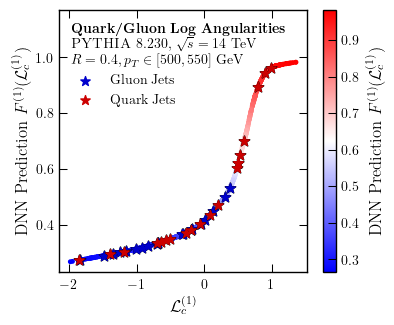

In [3]:
rocs = []
k_order = 1

(X_train, X_val, X_test,
    Y_train, Y_val, Y_test) = data_split(X[:,:k_order+1], Y, val=val, test=1500)

dense_sizes = (100, 100, 100)

dnn = DNN(input_dim=k_order+1, dense_sizes=dense_sizes, metrics = [tf.keras.metrics.AUC()], acts='LeakyReLU')

# train model
dnn.load_weights(f"Data_old/dnn/dnn_O{k_order}.keras")

# get predictions on test data
preds = dnn.predict(X_test, batch_size=1000)[:,1]

print(Y_test.shape)

fig, ax = newplot("column", aspect_ratio = 0.85)

gluon_mask = Y_test[:,1] == 0
quark_mask = Y_test[:,1] == 1

# plt.hist(preds[gluon_mask], bins=100, range=(0,1), histtype='step', density=True, label='Gluon')
# plt.hist(preds[quark_mask], bins=100, range=(0,1), histtype='step', density=True, label='Quark')


temp = plt.scatter(X_test[:,1], preds, c = preds, cmap="bwr")


n_star = 20
plt.scatter(X_test[gluon_mask,1][:n_star], preds[gluon_mask][:n_star], color = "black", marker = "*", s = 125/2)
plt.scatter(X_test[gluon_mask,1][:n_star], preds[gluon_mask][:n_star], color = (0,0,0.8), marker = "*", s = 100/2, label = "Gluon Jets")

plt.scatter(X_test[quark_mask,1][:n_star], preds[quark_mask][:n_star], color = "black", marker = "*", s = 125/2)
plt.scatter(X_test[quark_mask,1][:n_star], preds[quark_mask][:n_star], color = (0.8,0,0), marker = "*", s = 100/2, label = "Quark Jets")


plt.xlabel(r"$\mathcal{L}^{(1)}_c$")
plt.ylabel("DNN Prediction $F^{(1)}(\mathcal{L}^{(1)}_c)$")


add_whitespace(ax, 1.15)
line_0 = r"Quark/Gluon Log Angularities"
line_1 = r"$\textsc{PYTHIA}$ $8.230$, $\sqrt{s} = 14$ TeV"
line_2 = "$R = 0.4, p_T \in [500, 550]$ GeV"
stamp(0.05, 0.925, line_0 = line_0, line_1 = line_1, line_2 = line_2)
plt.legend(frameon = False, loc = "upper left", bbox_to_anchor = (0.0, 0.8))

# Colorbar
cbar = plt.colorbar(temp, cmap = "bwr", ax = ax)
cbar.set_label(r"DNN Prediction $F^{(1)}(\mathcal{L}^{(1)}_c)$",)

plt.savefig("Plots/Log_Angularities_1.pdf", bbox_inches = "tight")


# for k_order in [1, 2, 3, 4]:


#     (X_train, X_val, X_test,
#     Y_train, Y_val, Y_test) = data_split(X[:,:k_order+1], Y, val=val, test=test)

#     dense_sizes = (100, 100, 100)

#     dnn = DNN(input_dim=k_order+1, dense_sizes=dense_sizes, metrics = [tf.keras.metrics.AUC()], acts='LeakyReLU')

#     # train model
#     dnn.load_weights(f"Data/dnn/dnn_O{k_order}.keras")

#     # get predictions on test data
#     preds = dnn.predict(X_test, batch_size=1000)


#     # get ROC curve if we have sklearn
#     if roc_curve:
#         rocs.append(roc_curve(Y_test[:,1], preds[:,1]))

#         # get area under the ROC curve
#         auc = roc_auc_score(Y_test[:,1], preds[:,1])
#         print()
#         print('AUC:', auc)
#         print()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 3)]               0         
                                                                 
 dense_0 (Dense)             (None, 100)               400       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 100)               0   

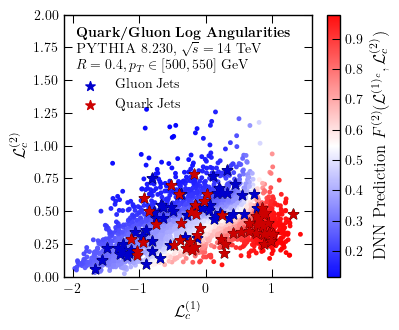

In [4]:
rocs = []
k_order = 2

(X_train, X_val, X_test,
    Y_train, Y_val, Y_test) = data_split(X[:,:k_order+1], Y, val=val, test=2500)

dense_sizes = (100, 100, 100)

dnn = DNN(input_dim=k_order+1, dense_sizes=dense_sizes, metrics = [tf.keras.metrics.AUC()], acts='LeakyReLU')

# train model
dnn.load_weights(f"Data_old/dnn/dnn_O{k_order}.keras")

# get predictions on test data
preds = dnn.predict(X_test, batch_size=1000)[:,1]

auc = roc_auc_score(Y_test[:,1], preds)
print()
print('AUC:', auc)



# Plot

fig, ax = newplot("column", aspect_ratio = 0.85)
temp = plt.scatter((X_test[:,1]), (X_test[:,2] - (X_test[:,1]**2)), c = preds, cmap="bwr", alpha = 0.95, edgecolors= None)

gluon_mask = Y_test[:,1] == 0
quark_mask = Y_test[:,1] == 1

n_star = 50
plt.scatter(X_test[gluon_mask,1][:n_star], X_test[gluon_mask,2][:n_star] - (X_test[gluon_mask,1][:n_star]**2), color = "black", marker = "*", s = 125/2)
plt.scatter(X_test[gluon_mask,1][:n_star], X_test[gluon_mask,2][:n_star] - (X_test[gluon_mask,1][:n_star]**2), color = (0,0,0.8), marker = "*", s = 100/2, label = "Gluon Jets")

plt.scatter(X_test[quark_mask,1][:n_star], X_test[quark_mask,2][:n_star] - (X_test[quark_mask,1][:n_star]**2), color = "black", marker = "*", s = 125/2)
plt.scatter(X_test[quark_mask,1][:n_star], X_test[quark_mask,2][:n_star] - (X_test[quark_mask,1][:n_star]**2), color = (0.8,0,0), marker = "*", s = 100/2, label = "Quark Jets")


# plt.plot(np.linspace(-2, 2, 150),np.sqrt(np.linspace(-2, 2, 150)**2), color = "black", alpha = 0.5, ls = "--", label = "Bound" )


cbar = plt.colorbar(temp, cmap = "bwr")
plt.xlabel(r"$\mathcal{L}^{(1)}_c$")
plt.ylabel(r"$\mathcal{L}^{(2)}_c$")
cbar.set_label("DNN Prediction $F^{(2)}(\mathcal{L}^{(1)_c}, \mathcal{L}^{(2)}_c)$",)


add_whitespace(ax, 1.15)
line_0 = "Quark/Gluon Log Angularities"
line_1 = r"$\textsc{PYTHIA}$ $8.230$, $\sqrt{s} = 14$ TeV"
line_2 = "$R = 0.4, p_T \in [500, 550]$ GeV"
stamp(0.05, 0.925, line_0 = line_0, line_1 = line_1, line_2 = line_2)
plt.legend(frameon = False, loc = "upper left", bbox_to_anchor = (0.0, 0.8))

plt.ylim(0, 2)

plt.savefig("Plots/Log_Angularities_2.pdf", bbox_inches = "tight")

# for k_order in [1, 2, 3, 4]:


#     (X_train, X_val, X_test,
#     Y_train, Y_val, Y_test) = data_split(X[:,:k_order+1], Y, val=val, test=test)

#     dense_sizes = (100, 100, 100)

#     dnn = DNN(input_dim=k_order+1, dense_sizes=dense_sizes, metrics = [tf.keras.metrics.AUC()], acts='LeakyReLU')

#     # train model
#     dnn.load_weights(f"Data/dnn/dnn_O{k_order}.keras")

#     # get predictions on test data
#     preds = dnn.predict(X_test, batch_size=1000)


#     # get ROC curve if we have sklearn
#     if roc_curve:
#         rocs.append(roc_curve(Y_test[:,1], preds[:,1]))

#         # get area under the ROC curve
#         auc = roc_auc_score(Y_test[:,1], preds[:,1])
#         print()
#         print('AUC:', auc)
#         print()

# k = 3

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 4)]               0         
                                                                 
 dense_0 (Dense)             (None, 100)               500       
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 100)               0   

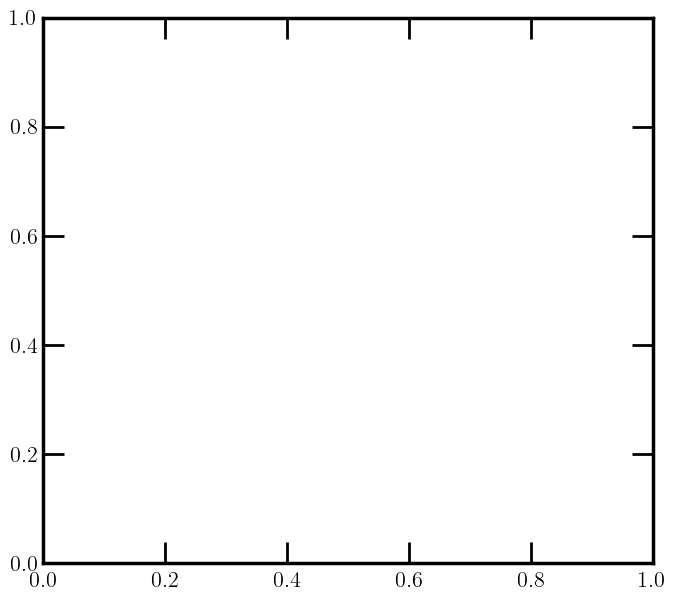

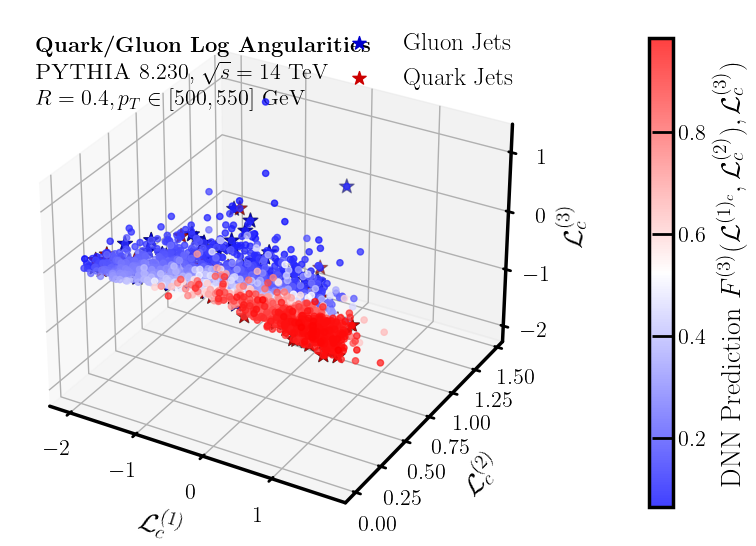

In [5]:
 
# importing required libraries
from mpl_toolkits.mplot3d import Axes3D


rocs = []
k_order = 3

newplot("full", aspect_ratio = 0.9)
fig = plt.figure(figsize=(8, 6))
# plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['figure.autolayout'] = True
# plt.rcParams['font.size'] = str(18)
ax = fig.add_subplot(projection='3d')

(X_train, X_val, X_test,
    Y_train, Y_val, Y_test) = data_split(X[:,:k_order+1], Y, val=val, test=2500)

dense_sizes = (100, 100, 100)

dnn = DNN(input_dim=k_order+1, dense_sizes=dense_sizes, metrics = [tf.keras.metrics.AUC()], acts='LeakyReLU')

# train model
dnn.load_weights(f"Data_old/dnn/dnn_O{k_order}.keras")

# get predictions on test data
preds = dnn.predict(X_test, batch_size=1000)[:,1]

cumulant_1 = X_test[:,1]
cumulant_2 = X_test[:,2] - (X_test[:,1]**2)
cumulant_3 = X_test[:,3] - (3*X_test[:,1]*X_test[:,2]) + (2*X_test[:,1]**3)
temp = ax.scatter(cumulant_1, cumulant_2 , cumulant_3, c = preds, cmap="bwr", alpha = 0.75, edgecolors= None)

gluon_mask = Y_test[:,1] == 0
quark_mask = Y_test[:,1] == 1

n_star = 150
ax.scatter(X_test[gluon_mask,1][:n_star], cumulant_2[gluon_mask][:n_star], cumulant_3[gluon_mask][:n_star], color = "black", marker = "*", s = 125)
ax.scatter(X_test[gluon_mask,1][:n_star], cumulant_2[gluon_mask][:n_star], cumulant_3[gluon_mask][:n_star], color = (0,0,0.8), marker = "*", s = 100, label = "Gluon Jets")

ax.scatter(X_test[quark_mask,1][:n_star], cumulant_2[quark_mask][:n_star], cumulant_3[quark_mask][:n_star], color = "black", marker = "*", s = 125)
ax.scatter(X_test[quark_mask,1][:n_star], cumulant_2[quark_mask][:n_star], cumulant_3[quark_mask][:n_star], color = (0.8,0,0), marker = "*", s = 100, label = "Quark Jets")



# Stamp
line_0 = r"\textbf{Quark/Gluon Log Angularities}"
line_1 = r"$\textsc{PYTHIA}$ $8.230$, $\sqrt{s} = 14$ TeV"
line_2 = "$R = 0.4, p_T \in [500, 550]$ GeV"

ax.text2D(0.05, 0.95, line_0, verticalalignment='top', transform=ax.transAxes, weight = "bold")
ax.text2D(0.05, 0.90, line_1,  verticalalignment='top', transform=ax.transAxes)
ax.text2D(0.05, 0.85, line_2,  verticalalignment='top', transform=ax.transAxes)
          

# stamp(0.05, 0.95, line_0 = line_0, line_1 = line_1, line_2 = line_2)
plt.legend(frameon = False, loc = "upper right")


# ax.set_colorbar(cmap = "bwr")
ax.set_xlabel(r"$\mathcal{L}^{(1)}_c$", labelpad=15)
ax.set_ylabel(r"$\mathcal{L}^{(2)}_c$", labelpad=15)
ax.set_zlabel(r"$\mathcal{L}^{(3)}_c$", labelpad=8)

cbar = plt.colorbar(temp, cmap = "bwr", shrink=0.85, pad = 0.125)
cbar.set_label("DNN Prediction $F^{(3)}(\mathcal{L}^{(1)_c}, \mathcal{L}^{(2)}_c), \mathcal{L}^{(3)}_c)$",)


plt.savefig("Plots/Log_Angularities_3.pdf", bbox_inches = "tight")




In [6]:
rocs = []
k_order = 1

(X_train, X_val, X_test,
    Y_train, Y_val, Y_test) = data_split(X[:,:k_order+1], Y, val=val, test=test)

dense_sizes = (100, 100, 100)

dnn = DNN(input_dim=k_order+1, dense_sizes=dense_sizes, metrics = [tf.keras.metrics.AUC()], acts='LeakyReLU')

# train model
dnn.load_weights(f"Data/dnn/dnn_O{k_order}.keras")

# get predictions on test data
preds = dnn.predict(X_test, batch_size=1000)[:,1]

print(Y_test.shape)

fig, ax = newplot(width = 9)

gluon_mask = Y_test[:,1] == 0
quark_mask = Y_test[:,1] == 1

# plt.hist(preds[gluon_mask], bins=100, range=(0,1), histtype='step', density=True, label='Gluon')
# plt.hist(preds[quark_mask], bins=100, range=(0,1), histtype='step', density=True, label='Quark')


temp = plt.scatter(X_test[:,1], preds, c = preds, cmap="bwr")


n_star = 20
plt.scatter(X_test[gluon_mask,1][:n_star], preds[gluon_mask][:n_star], color = "black", marker = "*", s = 125)
plt.scatter(X_test[gluon_mask,1][:n_star], preds[gluon_mask][:n_star], color = "blue", marker = "*", s = 100, label = "Gluon Jets")

plt.scatter(X_test[quark_mask,1][:n_star], preds[quark_mask][:n_star], color = "black", marker = "*", s = 125)
plt.scatter(X_test[quark_mask,1][:n_star], preds[quark_mask][:n_star], color = "red", marker = "*", s = 100, label = "Quark Jets")


plt.xlabel(r"$\mathcal{L}^{(1)}$")
plt.ylabel("DNN Prediction $F(\mathcal{L}^{(1)})$")

line_0 = "Quark/Gluon Log Angularities"
line_1 = "$PYTHIA$ $8.230$, $\sqrt{s} = 14$ TeV"
line_2 = "$R = 0.4, p_T \in [500, 550]$ GeV"
stamp(0.05, 0.95, line_0 = line_0, line_1 = line_1, line_2 = line_2, textops_update={"fontsize" : 18})
plt.legend(frameon = False, loc = "upper left", bbox_to_anchor = (0.0, 0.85))

# Colorbar
cbar = plt.colorbar(temp, cmap = "bwr", ax = ax)
cbar.set_label("DNN Prediction $F(\mathcal{L}^{(1)})$",)

# for k_order in [1, 2, 3, 4]:


#     (X_train, X_val, X_test,
#     Y_train, Y_val, Y_test) = data_split(X[:,:k_order+1], Y, val=val, test=test)

#     dense_sizes = (100, 100, 100)

#     dnn = DNN(input_dim=k_order+1, dense_sizes=dense_sizes, metrics = [tf.keras.metrics.AUC()], acts='LeakyReLU')

#     # train model
#     dnn.load_weights(f"Data/dnn/dnn_O{k_order}.keras")

#     # get predictions on test data
#     preds = dnn.predict(X_test, batch_size=1000)


#     # get ROC curve if we have sklearn
#     if roc_curve:
#         rocs.append(roc_curve(Y_test[:,1], preds[:,1]))

#         # get area under the ROC curve
#         auc = roc_auc_score(Y_test[:,1], preds[:,1])
#         print()
#         print('AUC:', auc)
#         print()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2)]               0         
                                                                 
 dense_0 (Dense)             (None, 100)               300       
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 100)               0   

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'Data/dnn/dnn_O1.keras', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)